# Skip-gram Negative Sampling with Tensorflow 

## Resources
* Mikolov et al (2013) [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) 
* Mikolov et al (2013) [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf)
* CS224n Lecture (2018) on [Word Vectors 1](http://web.stanford.edu/class/cs224n/lectures/lecture2.pdf)
* Tensorflow Tutorial [Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)
* Word2Vec Tutorial by Chris McCormick (2016): [The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
* Word2Vec Tutorial by Andy Thomas (2017) [Word2Vec word embedding tutorial in Python and TensorFlow](http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/) 
* Word Embeddings Series by Sebastian Ruder (2016-2017) [On word embeddings and a series of excellent posts](http://ruder.io/tag/word-embeddings/)

In [1]:
import tensorflow as tf
import numpy as np

import collections
import random
import os
import urllib
import zipfile

from datetime import datetime
from tempfile import gettempdir

from tensorboard.plugins import projector

## Download and read the data from file
Helper functions adapted from [Tensorflow's Github repository](https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [2]:
def maybe_download(url, filename, expected_bytes):
    "Download the file if not present, and make sure it's the right size."    
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename, local_filename)
        statinfo = os.stat(local_filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', filename)
        else:
            print(statinfo.st_size)
            raise Exception('Failed to verify ' + local_filename + '. Can you get to it with a browser?')
    return local_filename


def read_data(filename):
    "Extract the file enclosed in a zip file as a list of words (strings)."
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


def normalize_counter(counter):
    "Used to normalize the frequency "
    total = sum(counter.values())
    for w_idx in counter:
        counter[w_idx] /= total
    return counter


def build_dataset(words, n_words):
    "Process raw inputs into a dataset"
    count = collections.Counter(words).most_common(n_words - 1)
    dictionary = {'UNK': 0}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    for word in words:
        index = dictionary.get(word, 0) # words outside of most common n_words are replaced with UNK
        data.append(index)
    count = normalize_counter(collections.Counter(data)).most_common(n_words) # normalized counts
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


### Text8
http://mattmahoney.net/dc/textdata.html

In [3]:
filename = maybe_download(url='http://mattmahoney.net/dc/', filename='text8.zip', expected_bytes=31344016)

## Process the data and build the dictionaries

In [4]:
data = read_data(filename)
original_len = len(data)
print('Total number of words in text: {:,}.'.format(original_len))

MAX_VOCAB = 50000       # for this exercise, we train the most common 50,000 words in the text

# data               :  list of IDs (integers) representing the original words in the text
# count              :  maps IDs(integers) to normalized count of occurrences (word frequency in corpus)
# dictionary         :  maps words(strings) to their IDs(integers)
# reverse_dictionary :  maps IDs(integers) to words(strings)

data, count, dictionary, reverse_dictionary = build_dataset(data, MAX_VOCAB)
print('The 5 most common words (normalized counts):', [(reverse_dictionary[i], c) for i, c in count[:5]])
print('First 10 words in text:', data[:10], [reverse_dictionary[i] for i in data[:10]])

Total number of words in text: 17,005,207.
The 5 most common words (normalized counts): [('the', 0.06241594118789615), ('of', 0.034911483288618594), ('UNK', 0.024603699325741815), ('and', 0.02450008400368193), ('one', 0.02421399516042351)]
First 10 words in text: [5242, 3084, 12, 6, 195, 2, 3135, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Calculate frequencies for negative sampling and subsampling of frequent words
Sections 2.2 to 2.3 of Mikolov et al (2013) https://arxiv.org/pdf/1310.4546.pdf

In [5]:
def build_unigrams_dist(count):
    'Returns a list of normalized frequencies, indexed by each unique word in vocabulary'
    unigrams_dist = [0] * MAX_VOCAB
    for w_idx, count in count:
        unigrams_dist[w_idx] = count
    return unigrams_dist


In [6]:
unigram_dist = build_unigrams_dist(count) # used for noise distribution in negative sampling

### Subsampling of frequent words

In [7]:
def build_subsampling_dict(count, t=1e-3):
    "Formula from http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling"
    return {w_idx: (np.sqrt(f/t) + 1)*(t/f) for w_idx, f in count}


def subsample_words(data, count):
    "Algorithm from https://github.com/chrisjmccormick/word2vec_commented/blob/master/word2vec.c"
    subsampler = build_subsampling_dict(count)
    return [w for w in data if subsampler[w] >= 1 or subsampler[w] >= random.random()]
    

In [8]:
data = subsample_words(data, count)
difference = original_len - len(data)

print('Original text length: {:,} words.'.format(original_len))
print('Subsampled text length: {:,} words.'.format(len(data)))
print('Dropped {:.2f}% words ({:,} words)'.format(difference* 100 / original_len, difference))

Original text length: 17,005,207 words.
Subsampled text length: 12,502,743 words.
Dropped 26.48% words (4,502,464 words)


## Set the hyperparameter values

See Caselles-Dupré et al (2018) [Word2vec applied to Recommendation: Hyperparameters Matter](https://arxiv.org/pdf/1804.04212)

In [9]:
batch_size = 256        # How many training samples to process in parallel.
skip_window = 5         # How many words to consider on each side of center word.
num_skips = skip_window # How many times to reuse a center word to generate training sample.

embedding_size = 200    # Dimension of the embedding vector.
k_negative = 20         # Number of negative samples per correct sample.
                        # See https://github.com/tensorflow/tensorflow/issues/17949

ns_exp = 0.75           # The exponent to shape the negative sampling distribution

## Select validation set for monitoring training progress 

In [10]:
valid_size = 16     # Random set of words to evaluate training progress.
valid_window = 100  # Pick from most common 100 words.
                    # Adjustments to common words' embeddings are more likely to be observed
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

## Building the Tensorflow Graph 

In [11]:
graph = tf.Graph()
with graph.as_default(): 
    with tf.name_scope('fetch'):
        with tf.device('/cpu:0'):
            # Using the Data API to load and transform the data into inputs and labels.
            # See https://www.tensorflow.org/guide/datasets
            dataset = tf.data.Dataset.from_tensor_slices(np.array(data))
            dataset = dataset.apply(
                tf.contrib.data.sliding_window_batch(window_size=skip_window*2 + 1))
            labels = dataset.flat_map(
                lambda x: tf.data.Dataset.from_tensor_slices(
                    tf.expand_dims(                                 
                        tf.gather(x, random.sample(
                            [w for w in range(skip_window*2 + 1) if w != skip_window], 
                            num_skips)), axis=1)))
            inputs = dataset.flat_map(
                lambda x: tf.data.Dataset.from_tensor_slices(
                    tf.tile([x[skip_window]], [num_skips])))
            dataset = tf.data.Dataset.zip((inputs, labels))
            dataset = dataset.repeat()
            dataset = dataset.batch(batch_size)
            dataset = dataset.prefetch(1)
            iterator = dataset.make_initializable_iterator()
            train_inputs, train_labels = iterator.get_next()
    
    with tf.name_scope('validation'):
        valid_dataset = tf.constant(valid_examples, tf.int32)
    
    with tf.name_scope('embeddings'):
        embeddings = tf.get_variable('embedding_matrix', shape=(MAX_VOCAB, embedding_size), 
                                     initializer=tf.random_uniform_initializer(-1.0, 1.0))
        embedded_inputs = tf.nn.embedding_lookup(embeddings, train_inputs)
        
    with tf.name_scope('weights'):
        softmax_w = tf.get_variable('softmax_w', shape=(MAX_VOCAB, embedding_size),
                                    initializer=tf.truncated_normal_initializer(
                                        stddev=1.0/embedding_size**0.5))
        softmax_b = tf.get_variable('softmax_b', shape=(MAX_VOCAB),
                                    initializer=tf.zeros_initializer())
    
    # Tensorflow implementation of negative sampling.
    # Construct a candidate sampler and use it with a sampled loss function.
    # See https://www.tensorflow.org/api_guides/python/nn#Candidate_Sampling
    with tf.name_scope('loss'):
        sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes=train_labels,
                                                        num_true=1,
                                                        num_sampled=k_negative,
                                                        unique=True,
                                                        range_max=MAX_VOCAB,
                                                        distortion=ns_exp,  
                                                     num_reserved_ids=0,     
                                                        unigrams=unigram_dist)
        
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_w,
                                                         biases=softmax_b,
                                                         labels=train_labels,
                                                         inputs=embedded_inputs,
                                                         num_sampled=k_negative,
                                                         num_classes=MAX_VOCAB,
                                                         sampled_values=sampler))
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        train_op = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # Find the embeddings most similiar to the validation examples based on cosine similarity 
    with tf.name_scope('similarity'):
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

In [12]:
def get_logdir():
    root_logdir = 'tf_logs'
    if not os.path.exists(root_logdir):
        os.makedirs(root_logdir)
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    return "{}/run_{}/".format(root_logdir, now)

## Create session and train model 

In [13]:
NUM_STEPS = int(round(len(data) * num_skips / batch_size))  # train for 1 epoch over text
log_dir = get_logdir()

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter(log_dir, graph) # writer for displaying loss in tensorboard
    sess.run([init, iterator.initializer])         # initialize variables and dataset iterator
    print('Initialized.')
    
    average_loss = 0
    for step in range(NUM_STEPS):
        run_metadata = tf.RunMetadata()
        _, summary, loss_val = sess.run([train_op, merged, loss], run_metadata=run_metadata)
        average_loss += loss_val
        writer.add_summary(summary, step)
        
        if step == NUM_STEPS - 1:
            writer.add_run_metadata(run_metadata, 'step{}'.format(step))
            
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step {}: {}'.format(step, average_loss))
            average_loss = 0
            
        # Print top_k most similar words for validation set (this is an expensive exercise)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 5
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest words to "{}": '.format(valid_word)
                close_words = [reverse_dictionary[nearest[k]] for k in range(top_k)]
                print(log_str, ', '.join(close_words))
    
    final_embeddings = normalized_embeddings.eval()
    
    # Save embedding labels (the words) for projecting in tensorboard
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(MAX_VOCAB):
            f.write(reverse_dictionary[i] + '\n')
    
    # Save model checkpoints
    saver.save(sess, os.path.join(log_dir, 'model.ckpt'))
    
    # Create tensorboard configuration for the embeddings
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)
    
writer.close()        

Initialized.
Average loss at step 0: 6.176535129547119
Nearest words to "by":  slideshow, hobsbawm, imaginative, paperback, facilitating
Nearest words to "three":  saltire, hummer, intelligible, agatha, nbs
Nearest words to "states":  unfinished, allegations, unpaved, grandson, volt
Nearest words to "may":  meninges, whitehead, uses, lesson, shaky
Nearest words to "united":  appletalk, nicodemus, indiana, nimitz, sor
Nearest words to "their":  telco, workstations, stats, land, enlargement
Nearest words to "on":  updates, kohlrabi, plantae, soldiery, ethidium
Nearest words to "been":  headstone, bows, nigsberg, endorsement, consecutively
Nearest words to "most":  centimeter, badger, sefirot, interpolation, gagauz
Nearest words to "time":  pwnage, lan, consequentialist, rida, unquestionably
Nearest words to "used":  thoroughbred, horse, maple, hoffa, cannon
Nearest words to "many":  brainiac, search, coffin, southward, owing
Nearest words to "one":  cdb, humps, airports, ecstasy, shorten

Average loss at step 102000: 2.910283071577549
Average loss at step 104000: 2.897515479505062
Average loss at step 106000: 2.85212380695343
Average loss at step 108000: 2.8777727347016335
Average loss at step 110000: 2.8502667313218115
Average loss at step 112000: 2.89280017888546
Average loss at step 114000: 2.900582159936428
Average loss at step 116000: 2.870245892763138
Average loss at step 118000: 2.897209606945515
Average loss at step 120000: 2.838640541255474
Nearest words to "by":  with, of, in, as, and
Nearest words to "three":  four, five, six, seven, two
Nearest words to "states":  united, volt, ankh, meltwater, unfinished
Nearest words to "may":  can, to, will, pubescent, meninges
Nearest words to "united":  appletalk, nicodemus, states, nimitz, rights
Nearest words to "their":  his, land, koan, its, they
Nearest words to "on":  in, with, from, the, told
Nearest words to "been":  be, was, headstone, castrati, contain
Nearest words to "most":  more, very, sefirot, remained, b

Average loss at step 222000: 2.7452670840620996
Average loss at step 224000: 2.6852283169031144
Average loss at step 226000: 2.8058628209233283
Average loss at step 228000: 2.830390475153923
Average loss at step 230000: 2.72524512553215
Average loss at step 232000: 2.8330584760308266
Average loss at step 234000: 2.832767039299011
Average loss at step 236000: 2.8106938892006874
Average loss at step 238000: 2.818113673388958
Average loss at step 240000: 2.7882495528161524
Nearest words to "by":  with, from, of, for, as
Nearest words to "three":  four, five, eight, six, two
Nearest words to "states":  united, state, volt, nero, assaulted
Nearest words to "may":  can, would, will, to, pubescent
Nearest words to "united":  states, appletalk, nimitz, bilge, hardin
Nearest words to "their":  its, his, the, they, these
Nearest words to "on":  with, from, provides, for, by
Nearest words to "been":  be, was, were, nigsberg, also
Nearest words to "most":  more, very, many, sefirot, remained
Neare

## Plot the embeddings after applying PCA 
Source: https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [14]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.savefig(filename)

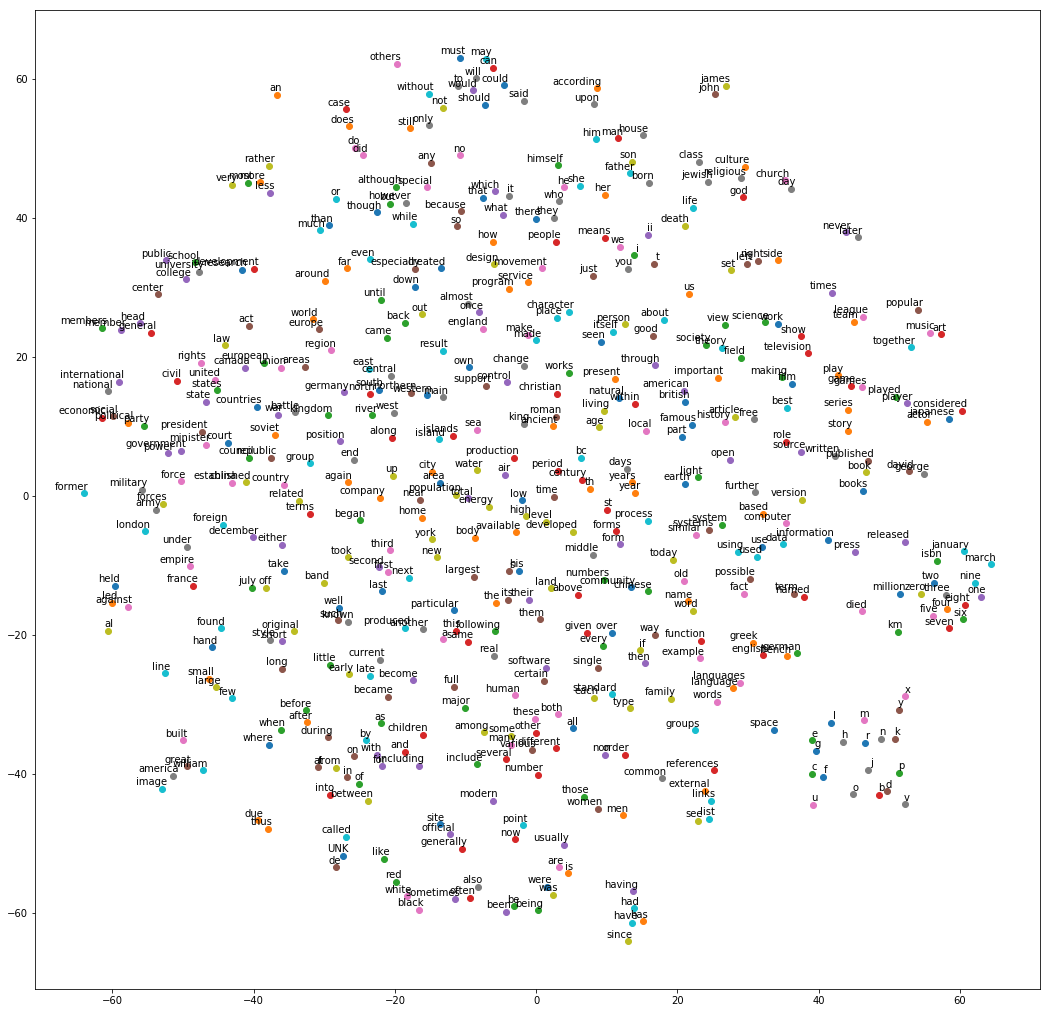

In [16]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)